# Memory

We've used Human-in-the-Loop (HITL) to allow users to review, provide feedback on, or correct the assistant's decisions. This is great, but it would be even better if the assistant *could learn from* the user's edit / feedback and adapt to their preferences over time. This is where memory comes in. Memory is a critical and emerging component of agent systems, allowing them to learn and improve over time. In this section, we'll add memory to our email assistant, allowing it to learn from user feedback and adapt to their preferences over time. This gives us more confidence that the assistant acts on our behalf with personalization. 

![overview-img](img/overview_memory.png)

## Memory in LangGraph

### Thread-Scoped and Across-Thread Memory

First, it's worth explaining how [memory works in LangGraph](https://langchain-ai.github.io/langgraph/concepts/memory/). LangGraph offers two distinct types of memory that serve complementary purposes in agent systems:

**Thread-Scoped Memory (Short-term)** operates within the boundaries of a single conversation thread. It's automatically managed as part of the graph's state and persisted through thread-scoped checkpoints. This memory type retains conversation history, uploaded files, retrieved documents, and other artifacts generated during the interaction. Think of it as the working memory that maintains context within one specific conversation, allowing the agent to reference earlier messages or actions without starting from scratch each time.

**Across-Thread Memory (Long-term)** extends beyond individual conversations, creating a persistent knowledge base that spans multiple sessions. This memory is stored as JSON documents in a memory store, organized by namespaces (like folders) and distinct keys (like filenames). Unlike thread-scoped memory, this information persists even after conversations end, enabling the system to recall user preferences, past decisions, and accumulated knowledge. This is what allows an agent to truly learn and adapt over time, rather than treating each interaction as isolated.

![short-vs-long-term-memory](img/short-vs-long.png)

The [Store](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore) is the foundation of this architecture, providing a flexible database where memories can be organized, retrieved, and updated. What makes this approach powerful is that regardless of which memory type you're working with, the same Store interface provides consistent access patterns. This allows your agent's code to remain unchanged whether you're using a simple in-memory implementation during development or a production-grade database in deployment. 

### LangGraph Store

LangGraph offers different [Store implementations depending on your deployment scenario](https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.BaseStore):

1. **Pure In-Memory (e.g., notebooks)**:
   - Uses `from langgraph.store.memory import InMemoryStore`
   - Purely a Python dictionary in memory with no persistence
   - Data is lost when the process terminates
   - Useful for quick experiments and testing
   - Includes semantic search with cosine similarity

2. **Local Development with `langgraph dev`**:
   - Similar to InMemoryStore but with pseudo-persistence
   - Data is pickled to the local filesystem between restarts
   - Lightweight and fast, no need for external databases
   - Semantic search uses cosine similarity for embedding comparisons
   - Great for development but not designed for production use

3. **LangGraph Platform or Production Deployments**:
   - Uses PostgreSQL with pgvector for production-grade persistence
   - Fully persistent data storage with reliable backups
   - Scalable for larger datasets
   - High-performance semantic search via pgvector
   - Default distance metric is cosine similarity (customizable)

Let's use the `InMemoryStore` here in the notebook! 

In [51]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

Memories are namespaced by a tuple, which in this specific example will be (`<user_id>`, "memories"). The namespace can be any length and represent anything, does not have to be user specific.

In [52]:
user_id = "1"
namespace_for_memory = (user_id, "memories")

We use the `store.put` method to save memories to our namespace in the store. When we do this, we specify the namespace, as defined above, and a key-value pair for the memory: the key is simply a unique identifier for the memory (memory_id) and the value (a dictionary) is the memory itself.

In [53]:
import uuid
memory_id = str(uuid.uuid4())
memory = {"food_preference" : "I like pizza"}
in_memory_store.put(namespace_for_memory, memory_id, memory)

We can read out memories in our namespace using the `store.search` method, which will return all memories for a given user as a list. The most recent memory is the last in the list. Each memory type is a Python class (`Item`) with certain attributes. We can access it as a dictionary by converting via `.dict` as above. The attributes it has are shown below, but the most important ones is typically `value`.

In [54]:
memories = in_memory_store.search(namespace_for_memory)
memories[-1].dict()

{'namespace': ['1', 'memories'],
 'key': 'd495e1d1-a21e-49bf-a4a1-cc46b42ff5fd',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-04-17T03:12:16.148584+00:00',
 'updated_at': '2025-04-17T03:12:16.148587+00:00',
 'score': None}

To use this in a graph, all we need to do is compile the graph with the store:

```
# We need this because we want to enable threads (conversations)
from langgraph.checkpoint.memory import InMemorySaver
checkpointer = InMemorySaver()
# We need this because we want to enable across-thread memory
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()
# Compile the graph with the checkpointer and store
graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)
```

The store is then accessible in any node of the graph, as we'll see below!

## Memory in LangGraph

Let's take our graph used with HITL and add memory to it.

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/Users/rlm/Desktop/Code/interrupt_workshop


Here we set up the triage router node, which is the first node in our graph.

In [2]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore
from langgraph.types import interrupt, Command

from email_assistant.prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt_hitl_memory, default_triage_instructions, default_background, default_response_preferences, default_cal_preferences
from email_assistant.tools.default.prompt_templates import STANDARD_TOOLS_PROMPT
from email_assistant.schemas import State, RouterSchema, StateInput
from email_assistant.utils import parse_email, format_for_display, format_email_markdown

# Agent tools 
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
class Question(BaseModel):
      """Question to ask user."""
      content: str

@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool
    
# All tools available to the agent
tools = [
    write_email, 
    schedule_meeting, 
    check_calendar_availability, 
    Question, 
    Done
]

tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema) 

# Initialize the LLM, enforcing tool use (of any available tools) for agent
llm = init_chat_model("openai:gpt-4.1", tool_choice="required", temperature=0.0)
llm_with_tools = llm.bind_tools(tools)

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_97783/429474626.py:64: UserWarning: WARNING! tool_choice is not default parameter.
                tool_choice was transferred to model_kwargs.
                Please confirm that tool_choice is what you intended.
  llm = init_chat_model("openai:gpt-4.1", tool_choice="required", temperature=0.0)


Now, this is the critical part! We don't capture any feedback from the user in our graph. 

### Memory Management 

Let's change that by simply adding the feedback to the memory. What we *want* to do is fairly straightforward: we want to add the feedback to the memory `Store`. If we compile our graph with the store, we can access the store in any node. So that is not a problem! But we have to answer two questions: 1) how do we want the memory to be structured? 2) how do we want to update the memory? Let's create some helper functions to make this easier: we'll just store memories as string to keep things simple.

Note that we can use a few tricks from the [GPT-4.1 prompting guide]((https://cookbook.openai.com/examples/gpt4-1_prompting_guide)) to help us update the memory: 

* For optimal performance, repeat the key instructions at the start and end
* Create clear, explicit instructions 
* XML delimiters for structure
* Provide example 

In [3]:
def get_memory(store, namespace, default_content=None):
    """Get memory from the store or initialize with default if it doesn't exist.
    
    Args:
        store: LangGraph BaseStore instance to search for existing memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        default_content: Default content to use if memory doesn't exist
        
    Returns:
        str: The content of the memory profile, either from existing memory or the default
    """
    # Search for existing memory with namespace and key
    user_preferences = store.get(namespace, "user_preferences")
    
    # If memory exists, return its content (the value)
    if user_preferences:
        return user_preferences.value
    
    # If memory doesn't exist, add it to the store and return the default content
    else:
        # Namespace, key, value
        store.put(namespace, "user_preferences", default_content)
        user_preferences = default_content
    
    # Return the default content
    return user_preferences 

class UserPreferences(BaseModel):
    """User preferences."""
    preferences: str
    justification: str

MEMORY_UPDATE_INSTRUCTIONS = """
# Role and Objective
You are a memory profile manager for an email assistant agent that selectively updates user preferences based on feedback messages from human-in-the-loop interactions with the email assistant.

# Instructions
- NEVER overwrite the entire memory profile
- ONLY make targeted additions of new information
- ONLY update specific facts that are directly contradicted by feedback messages
- PRESERVE all other existing information in the profile
- Format the profile consistently with the original style
- Generate the profile as a string

# Reasoning Steps
1. Analyze the current memory profile structure and content
2. Review feedback messages from human-in-the-loop interactions
3. Extract relevant user preferences from these feedback messages (such as edits to emails/calendar invites, explicit feedback on assistant performance, user decisions to ignore certain emails)
4. Compare new information against existing profile
5. Identify only specific facts to add or update
6. Preserve all other existing information
7. Output the complete updated profile

# Example
<memory_profile>
RESPOND:
- wife
- specific questions
- system admin notifications
NOTIFY: 
- meeting invites
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</memory_profile>

<user_messages>
"The assistant shouldn't have responded to that system admin notification."
</user_messages>

<updated_profile>
RESPOND:
- wife
- specific questions
NOTIFY: 
- meeting invites
- system admin notifications
IGNORE:
- marketing emails
- company-wide announcements
- messages meant for other teams
</updated_profile>

# Process current profile for {namespace}
<memory_profile>
{current_profile}
</memory_profile>

Think step by step about what specific feedback is being provided and what specific information should be added or updated in the profile while preserving everything else."""

MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT = """
Remember:
- NEVER overwrite the entire profile
- ONLY make targeted additions or changes based on explicit feedback
- PRESERVE all existing information not directly contradicted
- Output the complete updated profile as a string
"""

def update_memory(store, namespace, messages):
    """Update memory profile in the store.
    
    Args:
        store: LangGraph BaseStore instance to update memory
        namespace: Tuple defining the memory namespace, e.g. ("email_assistant", "triage_preferences")
        messages: List of messages to update the memory with
    """

    # Get the existing memory
    user_preferences = store.get(namespace, "user_preferences")
    # Update the memory
    llm = init_chat_model("openai:gpt-4.1", temperature=0.0).with_structured_output(UserPreferences)
    result = llm.invoke(
        [
            {"role": "system", "content": MEMORY_UPDATE_INSTRUCTIONS.format(current_profile=user_preferences.value, namespace=namespace)},
            {"role": "user", "content": f"Think carefully and update the memory profile based upon these user messages:"}
        ] + messages
    )
    # Save the updated memory to the store
    store.put(namespace, "user_preferences", result.preferences)

The triage router now leverages stored memory to make more personalized classification decisions:

In [4]:
# Nodes 
def triage_router(state: State, store: BaseStore) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore.

    The triage step prevents the assistant from wasting time on:
    - Marketing emails and spam
    - Company-wide announcements
    - Messages meant for other teams
    """
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Search for existing triage_preferences memory
    triage_instructions = get_memory(store, ("email_assistant", "triage_preferences"), default_triage_instructions)

    # Format system prompt with background and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=triage_instructions,
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classification decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [{"role": "user",
                            "content": f"Respond to the email: {email_markdown}"
                        }],
        }
        
    elif classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")

        # Next node
        goto = END
        # Update the state
        update = {
            "classification_decision": classification,
        }

    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information") 

        # Next node
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": classification,
        }

    else:
        raise ValueError(f"Invalid classification: {classification}")
    
    return Command(goto=goto, update=update)

def triage_interrupt_handler(state: State, store: BaseStore) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step"""
    
    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification  
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [{"role": "user",
                "content": f"Email to notify user about: {email_markdown}"
                }]

    # Create interrupt for Agent Inbox
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {}
        },
        "config": {
            "allow_ignore": True,  
            "allow_respond": True,
            "allow_edit": False, 
            "allow_accept": False,  
        },
        # Email to show in Agent Inbox
        "description": email_markdown,
    }

    # Send to Agent Inbox and wait for response
    response = interrupt([request])[0]

    # If user provides feedback, go to response agent and use feedback to respond to email   
    if response["type"] == "response":
        # Add feedback to messages 
        user_input = response["args"]
        messages.append({"role": "user",
                        "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}"
                        })
        # Update memory with feedback
        update_memory(store, ("email_assistant", "triage_preferences"), [{
            "role": "user",
            "content": f"The user decided to respond to the email, so update the triage preferences to capture this."
        }] + messages)

        goto = "response_agent"

    # If user ignores email, go to END
    elif response["type"] == "ignore":
        # Make note of the user's decision to ignore the email
        messages.append({"role": "user",
                        "content": f"The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this."
                        })
        # Update memory with feedback using the memory manager
        update_memory(store, ("email_assistant", "triage_preferences"), messages)
        goto = END

    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state 
    update = {
        "messages": messages,
    }

    return Command(goto=goto, update=update)

### Incorporating Memory into LLM Responses

Now that we have memory managers set up, we need to use the stored preferences when generating responses. The `llm_call` function demonstrates how to retrieve and incorporate memory into the LLM's context:

In [5]:
def llm_call(state: State, store: BaseStore):
    """LLM decides whether to call a tool or not"""

    # Search for existing cal_preferences memory
    cal_preferences = get_memory(store, ("email_assistant", "cal_preferences"), default_cal_preferences)
    
    # Search for existing response_preferences memory
    response_preferences = get_memory(store, ("email_assistant", "response_preferences"), default_response_preferences)

    # Search for existing background memory
    # TODO: Here, semantic search over a facts collection of background information from emails could be added. 
    # background = get_memory(store, ("email_assistant", "background"), default_background)

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    {"role": "system", "content": agent_system_prompt_hitl_memory.format(tools_prompt=STANDARD_TOOLS_PROMPT,
                                                                                         background=default_background,
                                                                                         response_preferences=response_preferences, 
                                                                                         cal_preferences=cal_preferences)}
                ]
                + state["messages"]
            )
        ]
    }

### Memory Integration in the Interrupt Handler

The interrupt handler is where memory truly shines, as it's responsible for capturing user feedback and using it to update our various memory stores. This function showcases how we:

1. **Process User Feedback**: When a user edits an email response or provides feedback, we capture that information
2. **Update Relevant Memory**: We route the feedback to the appropriate memory manager based on the context
3. **Learn Continuously**: Each interaction becomes a learning opportunity for the system

Let's break down the key memory interactions:

In [6]:
def interrupt_handler(state: State, store: BaseStore) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt for human review of tool calls"""
    
    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        
        # Allowed tools for HITL
        hitl_tools = ["write_email", "schedule_meeting", "Question"]
        
        # If tool is not in our HITL list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute search_memory and other tools without interruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
            continue
            
        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(subject, author, to, email_thread)
        
        # Format tool call for display and prepend the original email
        tool_display = format_for_display(state, tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {
                "action": tool_call["name"],
                "args": tool_call["args"]
            },
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the responses 
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
                        
        elif response["type"] == "edit":

            # Tool selection 
            tool = tools_by_name[tool_call["name"]]
            
            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Save feedback in memory and update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":

                # Capture the initial tool call
                initial_tool_call = tool_call["name"] + ": " + str(tool_call["args"])

                # Update the AI message's tool call with edited content (reference to the message in the state)
                ai_message = state["messages"][-1]
                current_id = tool_call["id"]
                
                # Replace the original tool call with the edited one (any changes made to this reference affect the original object in the state)
                ai_message.tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                    {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
                ]
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # We update the memory
                update_memory(store, ("email_assistant", "response_preferences"), [{
                    "role": "user",
                    "content": f"User edited the email response. Here is the initial email generated by the assistant: {initial_tool_call}. Here is the edited email: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Save feedback in memory and update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":

                # Capture the initial tool call
                initial_tool_call = tool_call["name"] + ": " + str(tool_call["args"])

                # Update the AI message's tool call with edited content
                ai_message = state["messages"][-1]
                current_id = tool_call["id"]
                
                # Replace the original tool call with the edited one
                ai_message.tool_calls = [tc for tc in ai_message.tool_calls if tc["id"] != current_id] + [
                    {"type": "tool_call", "name": tool_call["name"], "args": edited_args, "id": current_id}
                ]
                
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)
                
                # Add only the tool response message
                result.append({"role": "tool", "content": observation, "tool_call_id": current_id})

                # Update the memory
                update_memory(store, ("email_assistant", "cal_preferences"), [{
                    "role": "user",
                    "content": f"User edited the calendar invitation. Here is the initial calendar invitation generated by the assistant: {initial_tool_call}. Here is the edited calendar invitation: {edited_args}. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])
            
            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":

            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this email draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # Update the memory by reflecting on the email tool call
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the email draft. That means they did not want to respond to the email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # Update the memory by reflecting on the full message history including the schedule_meeting tool call
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the calendar meeting draft. That means they did not want to schedule a meeting for this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append({"role": "tool", "content": "User ignored this question. Ignore this email and end the workflow.", "tool_call_id": tool_call["id"]})
                # Go to END
                goto = END
                # Update the memory by reflecting on the full message history including the Question tool call
                update_memory(store, ("email_assistant", "triage_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"The user ignored the Question. That means they did not want to answer the question or deal with this email. Update the triage preferences to ensure emails of this type are not classified as respond. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                update_memory(store, ("email_assistant", "response_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the response preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                update_memory(store, ("email_assistant", "cal_preferences"), state["messages"] + result + [{
                    "role": "user",
                    "content": f"User gave feedback, which we can use to update the calendar preferences. Follow all instructions above, and remember: {MEMORY_UPDATE_INSTRUCTIONS_REINFORCEMENT}."
                }])

            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with the user feedback to incorporate into the email
                result.append({"role": "tool", "content": f"User answered the question, which can we can use for any follow up actions. Feedback: {user_feedback}", "tool_call_id": tool_call["id"]})
                # TODO: Here, we could update the background information with the user's answer. 
                # update_memory(store, ("email_assistant", "background"), [{
                #     "role": "user",
                #     "content": f"Update background information based upon these messages:"
                # }] + state["messages"] + result)

            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

    # Update the state 
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

This is the same as before. 

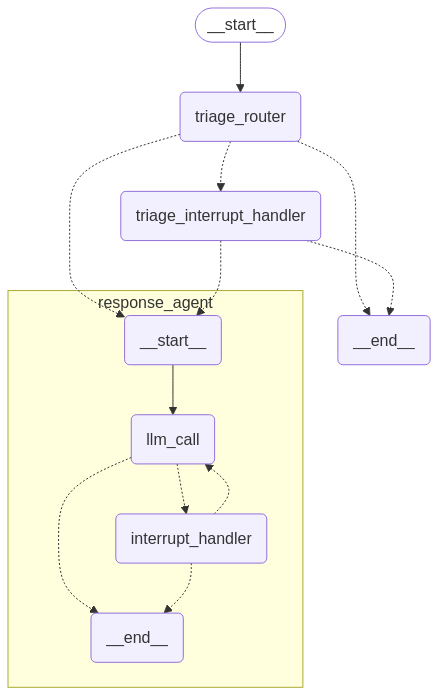

In [7]:
from IPython.display import Image, display

# Conditional edge function
def should_continue(state: State, store: BaseStore) -> Literal["interrupt_handler", END]:
    """Route to tool handler, or end if Done tool called"""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls: 
            if tool_call["name"] == "Done":
                # TODO: Here, we could update the background memory with the email-response for follow up actions. 
                return END
            else:
                return "interrupt_handler"

# Build workflow
agent_builder = StateGraph(State)

# Add nodes - with store parameter
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "interrupt_handler": "interrupt_handler",
        END: END,
    },
)

# Compile the agent
response_agent = agent_builder.compile()

# Build overall workflow with store and checkpointer
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
)

email_assistant = overall_workflow.compile()
display(Image(email_assistant.get_graph(xray=True).draw_mermaid_png()))


## Testing the agent with memory

Now that we've implemented memory into our email assistant, let's test how the system learns from user feedback and adapts over time. This testing section explores how different types of user interactions create distinct memory updates that improve the assistant's future performance.

The key questions we're answering through these tests:
1. How does the system capture and store user preferences?
2. How do these stored preferences affect future decisions?
3. What patterns of interaction lead to which types of memory updates?

First, let's build a helper function to display memory content so we can track how it evolves throughout our tests:

In [8]:
import uuid 
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command
from langgraph.store.memory import InMemoryStore

# Helper function to display memory content
def display_memory_content(store, namespace=None):
    # Display current memory content for all namespaces
    print("\n======= CURRENT MEMORY CONTENT =======")
    if namespace:
        memory = store.get(namespace, "user_preferences")
        if memory:
            print(f"\n--- {namespace[1]} ---")
            print({"preferences": memory.value})
        else:
            print(f"\n--- {namespace[1]} ---")
            print("No memory found")
    else:
        for namespace in [
            ("email_assistant", "triage_preferences"),
            ("email_assistant", "response_preferences"),
            ("email_assistant", "cal_preferences"),
            ("email_assistant", "background")
        ]:
            memory = store.get(namespace, "user_preferences")
            if memory:
                print(f"\n--- {namespace[1]} ---")
                print({"preferences": memory.value})
            else:
                print(f"\n--- {namespace[1]} ---")
                print("No memory found")
            print("=======================================\n")

## Accept `write_email` and `schedule_meeting`

Our first test examines what happens when a user accepts the agent's actions without modification. This baseline case helps us understand how the system behaves when no feedback is provided:

1. We'll use the same tax planning email from our previous tests
2. The system will classify it as "RESPOND" and propose scheduling a meeting
3. We'll accept the meeting schedule without changes
4. The agent will generate an email confirming the meeting
5. We'll accept the email without changes

This test demonstrates the default behavior of our memory-enabled system. When a user simply accepts proposed actions, we expect minimal or no memory updates since there's no explicit feedback to learn from. However, the system will still leverage existing memory (if any) when generating its responses.

In [25]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store)

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant inform

Accept the schedule_meeting tool call

As we examine the initial `schedule_meeting` proposal, note how the system uses existing memory to inform its decisions:

1. The default calendar preferences show a preference for 30-minute meetings, though the email requests 45 minutes
2. The agent still proposes a 45-minute meeting, respecting the sender's specific request
3. We accept this proposal without modification to see if simple acceptance triggers any memory updates

After running this step, we'll check the memory contents to confirm whether acceptance alone leads to memory updates. Simple acceptance represents the baseline user experience - the system works as intended without requiring adjustments.

In [26]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I am available on Tuesday, April 22nd at 2:00 PM for a 45-minute call to discuss tax planning strategies. I have scheduled the meeting accordingly.\n\nLooking forward to your suggestions and our discussion.\n\nBest regards,\nLance'}}


Accept the write_email tool call

Now we'll accept the email draft that confirms the meeting scheduling:

1. The email draft is generated with knowledge of our calendar preferences
2. It includes details about the meeting time, duration, and purpose
3. We'll accept it without changes to complete the baseline test case

After accepting, we'll check all memory stores to see if any updates occurred. As expected, simply accepting the agent's proposals doesn't provide strong learning signals - there's no clear feedback about what the user likes or dislikes about the agent's approach.

The trace link shows the complete workflow execution, where we can see that the memory is used in the LLM call for response generation, but no memory updates occur, which is the expected behavior for simple acceptances.

In [27]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting the write_email tool call
display_memory_content(store)


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_02WPNb2qpXXVx43d3Z0VzWqv)
 Call ID: call_02WPNb2qpXXVx43d3Z0VzWqv
  Args:
    done: True

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\

We can look at the full messages, and the trace: 

https://smith.langchain.com/public/86ff6474-29fe-452e-8829-b05a91b458eb/r

You'll notice that memory is used in the LLM call to respond. 

But the memory store *not* updated, because we haven't added any feedback via HITL.

In [28]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_6ZbPjmSN8h1bfl3tDCx5ssoj)
 Call ID: call_6ZbPjmSN8h1bfl3tDCx5ssoj
  Args:
    day: 2025-04-22
  check_calendar_availability (call_8M30JVmN7Wj2VlIcDqBE1995)
 Call ID: call_8M30JVmN7Wj2VlIcDqBE1995
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

## Edit `write_email` and `schedule_meeting`

This test explores how the system learns from direct edits to its proposed actions. When users modify the agent's suggestions, it creates clear, specific learning signals about their preferences:

1. We'll use the same tax planning email as before
2. When the agent proposes a 45-minute meeting, we'll edit it to:
   - Change the duration to 30 minutes (matching our stored preference)
   - Make the subject line more concise
3. When the agent drafts an email, we'll edit it to be:
   - Shorter and less formal
   - Structured differently

Edits provide the most explicit feedback about user preferences, letting the system learn exactly what changes are desired. We expect to see specific, targeted updates to our memory stores that reflect these edits.

In [29]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store,("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'}


Edit the `schedule_meeting` tool call

When we edit the meeting proposal, we're providing direct, explicit feedback about our preferences. This creates a significant learning opportunity for the system:

1. The agent initially proposes a 45-minute meeting (the duration requested in the email)
2. We edit it to 30 minutes and simplify the subject from "Tax Planning Strategies Discussion" to "Tax Planning Discussion"
3. This creates clear, specific feedback about our time preferences and naming conventions

After the edit, we'll check the calendar preferences memory store to see how it's updated. The memory update should capture both:
- Our preference for shorter 30-minute meetings
- Our preference for more concise meeting subjects

The trace reveals the precise memory update logic, showing how the system analyzes the difference between its proposal and our edits to extract meaningful patterns and preferences. We can see the detailed justification for each memory update, ensuring transparency in the learning process.

In [30]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30, # Changed from 45 to 30
    "preferred_day": "2025-04-22",
    "start_time": 14 # 2pm
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing schedule_meeting
print("\nChecking memory after editing schedule_meeting:")
display_memory_content(store,("email_assistant", "cal_preferences"))


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out regarding tax planning strategies for this year. I have scheduled a 30-minute call for us on Tuesday, April 22nd at 2:00 PM to discuss your suggestions and review potential savings opportunities. If you need a longer duration, please let me know and I can adjust the meeting accordingly.\n\nLooking forward to our discussion.\n\nBest regards,\nLance'}}

Checking memory after editing schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': "30 minute meetings are preferred, but 15 minute meetings are also acceptable. User prefers 30 minute meetings over longer durations such as 45 minutes when possible. User prefers concise meeting subjects (e.g., 'Tax Planning Discussion' instead of 'Tax Planning Stra

Looking at the memory after editing the calendar invitation, we can see that it's been updated with remarkably specific preferences:

1. The system has identified that we prefer 30-minute meetings over longer durations
2. It's also captured our preference for concise meeting subjects

What's particularly impressive about this memory update is:
- It doesn't just record our specific edit, but generalizes to a broader preference pattern
- It preserves all existing memory content while adding the new information
- It extracts multiple preference signals from a single edit interaction

Now, let's edit the email draft to see how the system captures different types of communication preferences:

In [ ]:
display_memory_content(store,("email_assistant", "response_preferences"))
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Thanks! I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}
for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after editing write_email
print("\nChecking memory after editing write_email:")
display_memory_content(store,("email_assistant", "response_preferences"))

Our email edit reveals even more sophisticated learning capabilities:

1. We've dramatically shortened and simplified the email content
2. We've changed the tone to be more casual
3. We've added a question asking for confirmation rather than assuming the time works
4. We've slightly altered the meeting details (day and time)

Looking at the updated memory, we can see that the system has extracted a key insight about our communication style:

```
When scheduling a meeting, ask the recipient to confirm if the proposed time works for them, rather than assuming and stating the meeting is already scheduled.
```

This demonstrates the system's ability to:
- Analyze our edit not just at a superficial level, but to understand intent
- Extract generalizable principles from specific examples
- Preserve all existing guidance while adding new insights
- Maintain the organization and structure of the memory

These targeted, high-quality memory updates will improve all future interactions without requiring repeated corrections.

In [32]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_3lgcL8JNtxaakOR8NqZyVH2n)
 Call ID: call_3lgcL8JNtxaakOR8NqZyVH2n
  Args:
    day: 2025-04-22
  check_calendar_availability (call_Ru9AMMrCf7wlWPcS9gV7ohCq)
 Call ID: call_Ru9AMMrCf7wlWPcS9gV7ohCq
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

## Ignore `write_email`, `schedule_meeting`, and `question`

This test explores how the system learns from rejection. When users ignore (reject) the agent's suggestions, it creates a strong signal about content they don't want to handle:

1. We'll first test ignoring a `schedule_meeting` request entirely
2. Then we'll test accepting a meeting but ignoring the follow-up email
3. Finally, we'll test ignoring a `question` for a different email context

These rejection signals help the system learn what types of emails and actions a user prefers not to deal with, leading to more appropriate triage decisions in the future. We expect significant updates to the triage preferences memory after each ignore action.

In [9]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_3 = uuid.uuid4()
thread_config_3 = {"configurable": {"thread_id": thread_id_3}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt
display_memory_content(store, ("email_assistant", "triage_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant inform

Ignore the `schedule_meeting` tool call

When we ignore a meeting scheduling request, we're signaling that we don't want to handle this type of email through the assistant. This creates a powerful learning opportunity about our triage preferences:

1. The assistant initially classified the tax planning email as "RESPOND"
2. But by ignoring the scheduling request, we indicate we'd prefer not to handle this type of email
3. The system needs to update its triage classification preferences to reflect this rejection

After ignoring the request, we'll check the triage preferences memory to see how the rejection affected the system's understanding. The memory update should show a new pattern added to the "not worth responding to" section, specifically about tax planning calls or similar recurring discussions.

The trace shows how the system processes this rejection, identifies the pattern, and updates the memory with specific justification for why this type of email should be classified differently in the future.

In [10]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after ignoring first tool call
print("\nChecking memory after ignoring first tool call:")
display_memory_content(store, ("email_assistant", "triage_preferences"))


Simulating user ignoring the schedule_meeting tool call...

Checking memory after ignoring first tool call:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "Emails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n- Client requests to schedule tax planning calls (unless explicitly instructed otherwise)\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\n- GitHub notifications\n\nEmails that are worth resp

Looking at the memory update after ignoring the schedule_meeting tool call, we can see a remarkable triage preference update:

1. The system has added "Client requests to schedule tax planning calls" to the "emails not worth responding to" section
2. It correctly identified the general pattern (scheduling routine calls) rather than overfitting to just this specific instance
3. It included the parenthetical note "(unless explicitly instructed otherwise)" to maintain flexibility

This update demonstrates the system's ability to:
- Infer general patterns from specific instances of rejection
- Update the triage filters that determine initial email classification
- Preserve the organization and priority of existing preferences
- Include appropriate qualifiers to avoid overly rigid rules

Next, let's see what happens when we accept the meeting but reject the email draft:

In [11]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_3 = uuid.uuid4()
thread_config_3 = {"configurable": {"thread_id": thread_id_3}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_3):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_3):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_3):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after ignoring second tool call
print("\nChecking memory after ignoring second tool call:")
display_memory_content(store, ("email_assistant", "triage_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}

Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out. I am available on Tuesday, April 22nd at 2:00 PM for a 45-minute call to discuss tax planning strategies. I have scheduled the meeting accordingly.\n\nLooking forward to your suggestions and the discussion.\n\nBest regards,\nLance'}}

Simulating user ignoring the write_email tool call...
================================= Tool Message =================================

User ignored this e

When we accept the meeting but ignore the email draft, we're sending a more nuanced signal about our preferences:

1. We're willing to schedule the meeting (accepting the first tool call)
2. But we don't want to send a confirmation email about it (ignoring the second tool call)

Looking at the memory update, we see another evolution of our triage preferences:

```
"Client requests to schedule routine calls (such as tax planning or similar recurring discussions)"
```

The system has:
- Broadened the pattern from just "tax planning calls" to "routine calls" generally
- Added examples in parentheses for clarity
- Positioned this in the "not worth responding to" section
- Maintained all other existing preferences

This demonstrates how the memory evolves over multiple interactions, becoming increasingly accurate and generalizable with each additional data point. The system is continuously refining its understanding based on our feedback patterns.

In [13]:
state = graph.get_state(thread_config_3)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_l9Jn2ghL4T0aPuMhjpXf36Ga)
 Call ID: call_l9Jn2ghL4T0aPuMhjpXf36Ga
  Args:
    day: 2025-04-22
  check_calendar_availability (call_8eOXPjqVpaIRDkABD80XRYUU)
 Call ID: call_8eOXPjqVpaIRDkABD80XRYUU
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

Now let's try an email that calls the `Question` tool

For our third rejection test, we'll use a different type of email - a casual social invitation about brunch. This gives us insight into how the system learns about personal vs. professional communication preferences:

1. The system classifies this personal invitation as "RESPOND"
2. Rather than answering directly, it uses the Question tool to ask for clarification
3. We'll ignore this question, indicating we don't want to handle these types of emails through the assistant

This test shows how ignoring questions (not just actions) can also update our triage preferences. By rejecting the clarification attempt, we signal that this entire category of email doesn't warrant response through the assistant.

In [14]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Meet Jim and Lisa for brunch in 3 weeks?",
    "email_thread": "Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about."
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_4 = uuid.uuid4()
thread_config_4 = {"configurable": {"thread_id": thread_id_4}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_4):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt for Question tool
display_memory_content(store, ("email_assistant", "triage_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Re: Meet Jim and Lisa for brunch in 3 weeks?', 'content': 'That sounds like a great idea! I checked my calendar for three weeks from now (Thursday, May 8th), and I’m available at 9:00 AM, 2:00 PM, or 4:00 PM. Do any of those times work for you, Jim, and Lisa? The new place on 17th sounds perfect.\n\nLet me know what everyone prefers and I’ll confirm the reservation.'}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examp

Ignore the `question` tool call

When we ignore a question from the assistant about a personal social invitation, we're providing yet another type of feedback:

1. The system initially tries to get clarification before responding
2. By ignoring the question, we indicate we don't even want to engage with this type of email
3. This suggests the entire category of social invitations should be handled differently

After ignoring, we'll check the triage preferences again to see how they've evolved. We expect to see a new entry about social invitations added to the "not worth responding to" section.

The memory update justification analyzes our rejection of the question about an informal social invitation and extracts a general pattern about our preference not to handle social invitations through the assistant.

In [15]:
print(f"\nSimulating user ignoring the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_4):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after ignoring Question tool
print("\nChecking memory after ignoring Question tool:")
display_memory_content(store, ("email_assistant", "triage_preferences"))


Simulating user ignoring the write_email tool call...

Checking memory after ignoring Question tool:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "Emails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n- Social invitations from partner (e.g., brunch plans, casual meetups)\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\n- GitHub notifications\n\nEmails that are worth responding to:\n- Direct quest

Looking at the memory update after ignoring the question about brunch plans, we see another sophisticated triage preference update:

```
"Social invitations from partner (e.g., brunch plans, casual meetups)"
```

This demonstrates how the system:
1. Correctly identifies personal social invitations as a distinct category
2. Specifically notes they're from "partner" - showing it's learning to distinguish senders
3. Provides examples to clarify the pattern
4. Adds this to the "not worth responding to" section

These three ignores have collectively taught the system quite a bit about what types of emails we prefer not to handle through the assistant:
- Tax planning calls and routine client scheduling
- Social invitations from partners
- Each with appropriate specificity and generalizability

In a real-world scenario, these learned preferences would ensure that similar future emails would be classified differently, saving the user time by automatically filtering out categories they've previously rejected.

In [16]:
state = graph.get_state(thread_config_4)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Meet Jim and Lisa for brunch in 3 weeks?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_5jTHskfgPCFQKakHl2dFxvsD)
 Call ID: call_5jTHskfgPCFQKakHl2dFxvsD
  Args:
    day: 2025-05-08
================================= Tool Message =================================

Available times on 2025-05-08: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ==================================
Tool Calls:
  write_email (call_3tvSXyHFCWGk4yzbBYMCdEWz)
 Call ID: call_3tvSXyHFCWGk4yzbBYMCdEWz
  Args:
    to: partner@home.com
    subject: Re: Meet Jim and Lisa for brunch in 3 week

## Respond (with feedback) `write_email`, `schedule_meeting`, and `question`

Our final test set explores the "response" feedback pattern - providing guidance without directly editing or accepting. This conversational feedback mechanism offers a middle ground between acceptance and editing:

1. First, we'll test feedback for meeting scheduling by requesting:
   - Shorter duration (30 minutes instead of 45)
   - Afternoon meeting times (after 2pm)
   
2. Next, we'll test feedback for email drafting by requesting:
   - Shorter, less formal language
   - A specific closing statement about looking forward to the meeting
   
3. Finally, we'll test feedback for questions by providing:
   - A direct answer with additional context
   - Specific preferences (brunch location, time)

This natural language feedback approach lets users guide the assistant without having to do the work themselves. We expect to see detailed memory updates that extract the general principles from our specific feedback.

In [21]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt 
display_memory_content(store, ("email_assistant", "cal_preferences"))

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 45, 'preferred_day': '2025-04-22', 'start_time': 14}}

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '\n30 minute meetings are preferred, but 15 minute meetings are also acceptable.\n'}


Provide feedback for the `schedule_meeting` tool call

Instead of directly editing the meeting proposal or simply accepting it, we'll provide natural language feedback:

1. We request a 30-minute meeting instead of 45 minutes
2. We express a preference for afternoon meetings after 2pm
3. The system must interpret this feedback and generate a new proposal

This conversational approach is often more natural and efficient than direct editing, especially for mobile users or those who prefer to give high-level direction rather than detailed edits.

After providing feedback, we'll examine the calendar preferences memory to see how this natural language guidance is captured. We expect to see the system extract both the meeting duration and time-of-day preferences as general principles.

In [22]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for schedule_meeting
print("\nChecking memory after providing feedback for schedule_meeting:")
display_memory_content(store, ("email_assistant", "cal_preferences"))


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Discussion', 'duration_minutes': 30, 'preferred_day': '2025-04-22', 'start_time': 14}}

Checking memory after providing feedback for schedule_meeting:

======= CURRENT MEMORY CONTENT =======

--- cal_preferences ---
{'preferences': '30 minute meetings are preferred, but 15 minute meetings are also acceptable.\nAfternoon meetings after 2pm are preferred.'}


Our memory check after providing feedback shows an elegantly simple calendar preference update:

```
30 minute meetings are preferred, but 15 minute meetings are also acceptable.
Afternoon meetings after 2pm are preferred.
```

The system has:
1. Captured both aspects of our feedback (duration and time of day)
2. Preserved the existing preference about 15-minute meetings
3. Added our preference for afternoon meetings after 2pm as a new line
4. Kept the format clean and readable

This natural language feedback mechanism creates the same quality of memory updates as direct editing but requires less effort from the user. The system is able to extract structured preferences from unstructured feedback, showing its ability to learn from conversational interactions.

Let's accept this revised meeting proposal and move to the email draft:

In [23]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting schedule_meeting after feedback
print("\nChecking memory after accepting schedule_meeting after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hello,\n\nThank you for reaching out regarding tax planning strategies. I am available on Tuesday, April 22nd at 2:00 PM, and have scheduled a 30-minute call for us to discuss your suggestions. If you need more time or would prefer a different slot, please let me know.\n\nLooking forward to our conversation.\n\nBest regards,\nLance'}}

Checking memory after accepting schedule_meeting after feedback:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (usi

Now provide feedback for the `write_email` tool call

Similar to our meeting feedback, we'll now provide natural language guidance for the email draft:

1. We request "shorter and less formal" language - a style preference
2. We ask for a specific closing statement about looking forward to the meeting
3. The system must interpret this guidance and rewrite the email accordingly

After providing this feedback, we'll check the response preferences memory to see how these style and structure preferences are captured. We expect to see generalizable guidelines about email brevity, formality, and closing statements added to our preference profile.

In [24]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for write_email
print("\nChecking memory after providing feedback for write_email:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThanks for reaching out. I’ve scheduled us for a 30-minute call on Tuesday, April 22nd at 2:00 PM to go over tax planning. Let me know if you need a different time.\n\nLooking forward to our chat!\n\nBest,\nLance'}}

Checking memory after providing feedback for write_email:

======= CURRENT MEMORY CONTENT =======

--- response_preferences ---
{'preferences': "Use professional and concise language. If the e-mail mentions a deadline, make sure to explicitly acknowledge and reference the deadline in your response.\n\nWhen responding to technical questions that require investigation:\n- Clearly state whether you will investigate or who you will ask\n- Provide an estimated timeline for when you'll have more information or complete the task\n\nWhen responding to eve

The memory update after our email feedback shows highly sophisticated learning about both meeting scheduling and email writing preferences:

1. The system has added a complete new section to the response preferences entitled "When writing email responses" with two key preferences:
   - "Favor shorter and less formal language when possible, unless the context requires formality"
   - "Include a closing statement expressing that you look forward to the meeting or conversation when confirming appointments"

2. It has also added a new bullet point to the "When responding to meeting scheduling requests" section:
   - "When scheduling meetings, prefer afternoon times after 2pm when possible, and default to 30-minute durations unless otherwise specified"

This demonstrates the system's ability to:
- Organize learned preferences into appropriate categories
- Extract multiple insights from a single feedback instance
- Apply meeting preferences to both calendar and email contexts
- Capture nuance with appropriate qualifiers ("when possible," "unless otherwise specified")
- Maintain the hierarchical structure of the memory

The resulting email shows all these preferences applied: it's shorter, less formal, includes a closing statement about looking forward to the chat, and correctly references the 30-minute meeting time.

In [25]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting write_email after feedback
print("\nChecking memory after accepting write_email after feedback:")
display_memory_content(store, ("email_assistant", "response_preferences"))


Simulating user accepting the write_email tool call...

Checking memory after accepting write_email after feedback:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\n- GitHub notifications\n\nEmails that are worth responding to:\n- Direct questions from team members requiring expertise\n- Meeting r

Look at the full message history.

In [26]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_SwwMW5F9zEWmajYTDLjKOoFN)
 Call ID: call_SwwMW5F9zEWmajYTDLjKOoFN
  Args:
    day: 2025-04-22
  check_calendar_availability (call_nIBAphQD4FFOdW89Ikc1uNfV)
 Call ID: call_nIBAphQD4FFOdW89Ikc1uNfV
  Args:
    day: 2025-04-24
================================= Tool Message =================================

Ava

Now let's try an email that calls the `Question` tool to provide feedback

Our final test examines feedback for questions. When the assistant needs clarification before proceeding, users can provide detailed information beyond just answering the question:

1. For the brunch invitation email, we'll provide feedback that includes:
   - Confirmation that we want to invite the people mentioned
   - A specific location preference (Jack's)
   - A time preference (before 11am)
   
2. This gives the system multiple pieces of information:
   - A direct answer to the question (yes, let's invite them)
   - Additional context and preferences not explicitly asked for

This tests the system's ability to process compound feedback and extract multiple data points from a single response.

In [27]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Meet Jim and Lisa for brunch in 3 weeks?",
    "email_thread": "Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about."
}

# Compile the graph
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt for Question tool
display_memory_content(store)

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'Do you want me to check your calendar and suggest specific dates and times for the brunch, or would you like to propose a particular day and time to Jim and Lisa first?'}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant inform

Provide feedback for the `Question` tool call

When the assistant asks about our preferences for the brunch invitation, we'll respond with rich, multi-faceted feedback:

1. We confirm we want to invite Jim and Lisa
2. We specify a location preference (Jack's, not the place on 17th)
3. We express a time preference (before 11am)

This tests the system's ability to handle compound responses that both answer the direct question and provide additional context. Note that we're not just answering "yes" or "no" - we're providing a rich context that should influence the assistant's next actions.

An ideal system would use this feedback to both respond to the immediate email and update background knowledge that could be relevant for future similar social invitations. In our current implementation, we don't update background knowledge from question responses, but this would be a straightforward enhancement.

In [28]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Yes, let's invite them, I really like brunch at Jack's, ideally before 11am."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after providing feedback for Question
print("\nChecking memory after providing feedback for Question:")
display_memory_content(store)


Simulating user providing feedback for the Question tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Brunch with Jim and Lisa in 3 Weeks', 'content': 'Great idea! I’ll reach out to Jim and Lisa to invite them to brunch at Jack’s in three weeks. I’ll suggest Saturday, May 8th, with a start time before 11am—9:00 AM is available on our calendar. Let me know if you’d like to suggest a different time or if this works for you before I send the invite.'}}

Checking memory after providing feedback for Question:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples 

Currently, we don't update `background_information` when the user provides feedback for the `Question` tool, but this would be a valuable enhancement.

Looking at how the system handled our question response:

1. It correctly incorporated all three key pieces of information:
   - Our affirmative decision to invite Jim and Lisa
   - Our location preference (Jack's, not the place on 17th)
   - Our time preference (before 11am)

2. It drafted a complete email that:
   - References reaching out to Jim and Lisa
   - Specifies Jack's as the location
   - Suggests a 9:00 AM time (before 11am as requested)
   - Asks for confirmation before sending an invite

This demonstrates the system's ability to extract and use detailed information from natural language feedback, even when not explicitly updating memory. The email correctly incorporates all aspects of our feedback and presents a coherent plan based on our preferences.

A future enhancement could store these preferences (location preferences, time preferences for social events) in the background information memory for use in future similar situations.

In [29]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting write_email after answering Question
print("\nChecking memory after accepting write_email after answering Question:")
display_memory_content(store)


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_k6NQ6GqqEIE1uNwVQXmx6xU6)
 Call ID: call_k6NQ6GqqEIE1uNwVQXmx6xU6
  Args:
    done: True

Checking memory after accepting write_email after answering Question:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR De

Look at the full message history

In [30]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 

**Subject**: Meet Jim and Lisa for brunch in 3 weeks?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, should we invite Jim and Lisa to brunch in 3 weeks? We could go to the new place on 17th that everyone is talking about.

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_dF0WQiJIDf5ovo5veMixbBm9)
 Call ID: call_dF0WQiJIDf5ovo5veMixbBm9
  Args:
    content: Do you want me to check your calendar and suggest specific dates and times for the brunch, or would you like to propose a particular day and time to Jim and Lisa first?
================================= Tool Message =================================

User answered the question, which can we can use for any follow up actions. Feedback: Yes, let's invite them, I really like brunch at Jack's, ideally before 11am.
==================

## Test Case for Notify Classification

This test explores how memory updates when an email is initially classified as "NOTIFY" but the user decides it needs a response:

1. The triage system initially classifies IT security updates as notifications
2. But the user decides this particular notification warrants acknowledgment
3. This creates a learning opportunity about which notification types need responses

The "notify" category is designed for important information that doesn't need immediate action. But user feedback can help the system learn which subset of notifications actually do warrant responses, refining the initial classification over time.

In [34]:
# Notify - Important FYI Email
email_input_notify = {
    "to": "Team Members <team@company.com>",
    "author": "IT Department <it@company.com>",
    "subject": "Critical Security Update",
    "email_thread": "Dear Team,\n\nThis is an important security notification. We will be updating our authentication system this weekend. During the update window (Saturday 2am-4am), you will not be able to access company resources.\n\nPlease ensure you log out of all systems before the maintenance window.\n\nRegards,\nIT Department"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_7 = uuid.uuid4()
thread_config_7 = {"configurable": {"thread_id": thread_id_7}}

# Run the graph until the first interrupt - should be classified as "notify"
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_notify}, config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt for Notify
display_memory_content(store, ("email_assistant", "triage_preferences"))

Running the graph until the first interrupt...
🔔 Classification: NOTIFY - This email contains important information

INTERRUPT OBJECT:
Action Request: {'action': 'Email Assistant: notify', 'args': {}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\n- GitHub notifications\n\nEmails that are worth r

Now simulate user deciding to respond with feedback.

This test explores the reclassification pathway from "notify" to "respond":

1. The system initially classifies a security update as information-only ("notify")
2. We're presented with this notification without a suggested action
3. We decide this security update actually requires acknowledgment
4. We provide feedback indicating we want to respond and confirm our compliance

This represents an important learning signal - that security notifications, particularly those requesting specific user actions, should be treated as items requiring response rather than just information.

After providing this feedback, we'll check the triage preferences memory to see how this "override" affects future classifications. We expect to see security notifications with action requests moved into the "worth responding to" section.

In [35]:
print("\nSimulating user deciding to respond with feedback...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "We should acknowledge receipt of this important notice and confirm that we'll be logged out before the maintenance window."}]), config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after responding with feedback to Notify
print("\nChecking memory after responding with feedback to Notify:")
display_memory_content(store, ("email_assistant", "triage_preferences"))


Simulating user deciding to respond with feedback...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'it@company.com', 'subject': 'Re: Critical Security Update', 'content': 'Dear IT Department,\n\nThank you for the notification regarding the upcoming authentication system update. I acknowledge receipt of this important notice and will ensure that I am logged out of all systems before the maintenance window begins on Saturday from 2am to 4am.\n\nBest regards,\nLance'}}

Checking memory after responding with feedback to Notify:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "Emails that are worth responding to:\n- Direct questions from team members requiring expertise\n- Meeting requests requiring confirmation\n- Critical bug reports related to team's projects\n- Requests from management requiring acknowledgment\n- Client inquiries about project status or features\n- Technical questions about documentation, code, or APIs (

The memory update after our decision to respond to a security notification shows a remarkable triage preference refinement:

1. The system has added a new bullet to the "Emails that are worth responding to" section:
   ```
   "Important security notifications from IT Department requiring acknowledgment or confirmation of action"
   ```

2. This update demonstrates:
   - Precision: It specifically identifies "security notifications" (not all IT emails)
   - Source awareness: It's from the "IT Department" specifically
   - Action trigger: It identifies notifications "requiring acknowledgment or confirmation"
   - Category reorganization: It moves this from "notify" to "respond" without removing notifications entirely

The system didn't just record our specific override - it analyzed the *reason* we might want to respond (acknowledging required action) and created a generalizable rule. This would ensure that future similar security notifications requesting specific user actions would be correctly classified as needing response.

In [36]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_7):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after accepting write_email for Notify
print("\nChecking memory after accepting write_email for Notify:")
display_memory_content(store, ("email_assistant", "triage_preferences"))


Simulating user accepting the write_email tool call...

Checking memory after accepting write_email for Notify:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "Emails that are worth responding to:\n- Direct questions from team members requiring expertise\n- Meeting requests requiring confirmation\n- Critical bug reports related to team's projects\n- Requests from management requiring acknowledgment\n- Client inquiries about project status or features\n- Technical questions about documentation, code, or APIs (especially questions about missing endpoints or features)\n- Personal reminders related to family (wife / daughter)\n- Personal reminder related to self-care (doctor appointments, etc)\n- Important security notifications from IT Department requiring acknowledgment or confirmation of action\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). E

Look at the full message history.

In [37]:
state = graph.get_state(thread_config_7)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Email to notify user about: 

**Subject**: Critical Security Update
**From**: IT Department <it@company.com>
**To**: Team Members <team@company.com>

Dear Team,

This is an important security notification. We will be updating our authentication system this weekend. During the update window (Saturday 2am-4am), you will not be able to access company resources.

Please ensure you log out of all systems before the maintenance window.

Regards,
IT Department

---

================================ Human Message =================================

User wants to reply to the email. Use this feedback to respond: We should acknowledge receipt of this important notice and confirm that we'll be logged out before the maintenance window.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_8tZq4eSFWr2WE01sPgEfgFr0)
 Call ID: call_8tZq4eSFWr2WE01sPgEfgFr0
  Args

## Test Case for Notify + Ignore

Our final test explores the opposite pattern - when a user decides notifications don't even warrant being shown:

1. The system classifies a company picnic announcement as a notification
2. The user decides this doesn't even warrant notification status
3. This creates a signal to further refine the classification boundaries

By ignoring certain types of notifications, users can teach the system which information is truly important to them versus which can be filtered out entirely. This completes the full spectrum of classification refinement.

In [39]:
# Notify - Important FYI Email
email_input_notify = {
    "to": "Team Members <team@company.com>",
    "author": "HR Department <hr@company.com>",
    "subject": "Company Picnic Next Month",
    "email_thread": "Dear Team,\n\nWe're planning the annual company picnic for next month. The tentative date is Saturday, June 15th from noon to 4pm at Central Park. There will be food, games, and activities for families.\n\nMore details will follow in the coming weeks.\n\nRegards,\nHR Department"
}

# Compile the graph with new thread
checkpointer = MemorySaver()
store = InMemoryStore()
graph = overall_workflow.compile(checkpointer=checkpointer, store=store)
thread_id_8 = uuid.uuid4()
thread_config_8 = {"configurable": {"thread_id": thread_id_8}}

# Run the graph until the first interrupt - should be classified as "notify"
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_notify}, config=thread_config_8):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after first interrupt for Notify + Ignore
display_memory_content(store, ("email_assistant", "triage_preferences"))

Running the graph until the first interrupt...
🔔 Classification: NOTIFY - This email contains important information

INTERRUPT OBJECT:
Action Request: {'action': 'Email Assistant: notify', 'args': {}}

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\n- GitHub notifications\n\nEmails that are worth r

Now simulate user deciding to ignore the notification.

In this final test, we explore the downgrade pathway from "notify" to "ignore":

1. The system initially classifies a company picnic announcement as "notify"
2. We decide we don't even want to be notified about these social events
3. By choosing "ignore," we signal this entire category should be filtered out

This represents another important learning signal - that certain types of company announcements (particularly social events) shouldn't even be surfaced as notifications, further refining our triage preferences.

After ignoring, we'll check the triage preferences memory for the final time to see how this override affects future classifications. We expect to see company social events moved from the "notify" section to the "not worth responding to" section.

In [40]:
print("\nSimulating user deciding to ignore the notification...")
for chunk in graph.stream(Command(resume=[{"type": "ignore"}]), config=thread_config_8):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

# Check memory after ignoring Notify
print("\nChecking memory after ignoring Notify:")
display_memory_content(store, ("email_assistant", "triage_preferences"))


Simulating user deciding to ignore the notification...

Checking memory after ignoring Notify:

======= CURRENT MEMORY CONTENT =======

--- triage_preferences ---
{'preferences': "\nEmails that are not worth responding to:\n- Marketing newsletters and promotional emails\n- Spam or suspicious emails\n- CC'd on FYI threads with no direct questions\n- Company social event announcements (e.g., company picnic)\n\nThere are also other things that should be known about, but don't require an email response. For these, you should notify (using the `notify` response). Examples of this include:\n- Team member out sick or on vacation\n- Build system notifications or deployments\n- Project status updates without action items\n- Important company announcements\n- FYI emails that contain relevant information for current projects\n- HR Department deadline reminders\n- Subscription status / renewal reminders\n- GitHub notifications\n\nEmails that are worth responding to:\n- Direct questions from team 

The final memory update completes our triage preference refinement journey:

1. The system has added "Company social event announcements (e.g., company picnic)" to the "Emails not worth responding to" section

2. This demonstrates:
   - Content-based categorization: It identifies "social event announcements" specifically
   - Example inclusion: It provides an example "(company picnic)" for clarity
   - Category downgrade: It moves this from "notify" to "not worth responding to"
   - Structural preservation: It maintains the original memory organization

Through our series of tests, we've now explored the full spectrum of triage learning:
- Upgrading notifications to responses (security updates)
- Downgrading notifications to ignores (company social events)
- Downgrading responses to ignores (personal social invitations, routine calls)
- Refining response preferences (meeting duration, timing, email style)

Each interaction has produced targeted, intelligent memory updates that maintain the overall structure while adding new insights. This continuous refinement creates an increasingly personalized assistant that learns and adapts to user preferences over time.

In [41]:
state = graph.get_state(thread_config_8)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Email to notify user about: 

**Subject**: Company Picnic Next Month
**From**: HR Department <hr@company.com>
**To**: Team Members <team@company.com>

Dear Team,

We're planning the annual company picnic for next month. The tentative date is Saturday, June 15th from noon to 4pm at Central Park. There will be food, games, and activities for families.

More details will follow in the coming weeks.

Regards,
HR Department

---

================================ Human Message =================================

The user decided to ignore the email even though it was classified as notify. Update triage preferences to capture this.


## Testing with Local Deployment

You can find this graph with memory integration in the `src/email_assistant` directory:

* `src/email_assistant/email_assistant_hitl_memory.py`

Testing this locally gives you the full experience of a memory-enabled HITL system:

1. **Start the local server**: Run `langgraph dev` to launch the agent locally
2. **Connect Agent Inbox**: Use the graph URL from the `langgraph.json` file
3. **Submit test emails**: Try different email types to see classification in action
4. **Provide various feedback types**: Try accepting, editing, ignoring, and responding
5. **Observe memory evolution**: Check the Memory tab in LangGraph Studio to see changes

![inbox](img/agent-inbox-edit.png)

The Memory tab in LangGraph Studio offers a real-time view of how your preferences are being captured and updated with each interaction:

![studio-img](img/memory-studio.png)

Through continued use, the system becomes increasingly personalized:
- It learns which emails you want to respond to, be notified about, or ignore
- It adapts to your communication style preferences
- It remembers your scheduling preferences
- It refines its understanding with each interaction

This combination of HITL and memory creates a system that balances automation with control - handling routine tasks automatically while learning from your feedback to become more aligned with your preferences over time.

In [ ]:
! langgraph dev

![inbox](img/agent-inbox-edit.png)

As you provide feedback or edit replies, you can see memories accumulate in the `memory` tab in LangGraph Studio.

![studio-img](img/memory-studio.png)



